<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/main/Easymoney_grupo5_2306_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE


## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff).

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado.
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**,

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?

¿Impactamos a todos lo segmentos indicados?

**Restricción de 10.000 clientes para la campaña.**

# Importación de librerías

In [1]:
import numpy as np # Arrays
import pandas as pd # Series and Dataframes

from google.colab import files

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
plt.style.use('ggplot') # Beautify Plots

#Modelling
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Definición funciones personalizadas

In [3]:
def preprocesado_basico(df, cid="pk_cid"):
  # Eliminar columna Unnamed
  df.drop("Unnamed: 0", axis = 1, inplace = True)

  # Renombrar columnas para alinear el naming
  df.rename({cid: "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

  # Cambiar a fecha la partition ID
  df['partition_ID'] = pd.to_datetime(df['partition_ID'])

In [4]:
def setOthers(dataframe, column, num_values=5):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('OTHERS')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('OTHERS')

In [5]:
def comprobar_shapes(df1,df2,df_final):
  print("DF1 = " + str(df1.shape))
  print("DF2 = " + str(df2.shape))
  print("DF_final = " + str(df_final.shape))

In [6]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print("***INFO***")
    print(df.info(verbose = verbose))

    print("***DESCRIPTIVOS CATEGORICAS***")
    try:
      print(df.describe(include = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***DESCRIPTIVOS NUMÉRICAS***")
    try:
      print(df.describe(exclude = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***NULOS***")
    total_nulos = df.isnull().sum().sum()
    print(df.isnull().sum())
    print(f"Tenemos un total de {total_nulos} nulos")

In [7]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

# Importación dataset

In [8]:
file_dir = "/content/drive/MyDrive/NUCLIO/TFM  Data Science/datasets_TFM_y_diccionario/" #Ricard file_dir
#file_dir = "/content/drive/MyDrive/TFM  Data Science/datasets_TFM_y_diccionario/" #Eva file_dir
#file_dir = "/content/drive/MyDrive/Master_DS/TFM_Data_Science/datasets_TFM_y_diccionario/" #Culebra file_dir

In [9]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"
file_provincias = "inform_adicional_por_provincias.csv"

In [10]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

In [11]:
info_provincias_raw = pd.read_csv(file_dir + file_provincias)

In [12]:
del file_dir
del file_sales
del file_product_description
del file_customer_sociodemographics
del file_customer_commercial_activity
del file_customer_products
del file_provincias

# 3.- PRE PROCESSING PARA CLUSTERING

## Sales

In [13]:
df_sales2 = sales_raw.copy()

In [14]:
# Eliminar columna Unnamed
df_sales2.drop("Unnamed: 0", axis = 1, inplace = True)

# Renombrar columnas para alinear el naming
df_sales2.rename({"cid": "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

#elimnar todas excepto,  month_sale, customer_id, y product_ID
df_sales2.drop("pk_sale", axis = 1, inplace = True)

# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
df_sales2["product_ID"] = df_sales2["product_ID"].astype("object")
df_sales2["customer_ID"] = df_sales2["customer_ID"].astype("object")

# Cambiar tipo de month_sale a fecha

df_sales2["month_sale"] = pd.to_datetime(df_sales2["month_sale"], format = "%Y/%m/%d")

# Cambiar tipo de customer_ID a número

df_sales2['customer_ID']=df_sales2['customer_ID'].astype('int')


In [15]:
df_sales2.head()

,customer_ID,month_sale,product_ID,net_margin
0,33620,2018-05-01,2335,952.9
1,35063,2018-06-01,2335,1625.2
2,37299,2018-02-01,2335,1279.7
3,39997,2018-02-01,2335,1511.9
4,44012,2018-02-01,2335,1680.3


In [16]:
# Total facturado por cliente
gb_total_fact = df_sales2.groupby("customer_ID").agg(
    facturacion_total = ("net_margin", "sum"),
    pedido_min = ("net_margin", "min"),
    pedido_max = ("net_margin", "max"),
    pedido_mean = ("net_margin", "mean"),
)
print(gb_total_fact.shape)
print()
print(gb_total_fact.head())
gb_total_fact = gb_total_fact.reset_index()

(152754, 4)

             facturacion_total  pedido_min  pedido_max  pedido_mean
customer_ID                                                        
15891                     66.4        66.4        66.4        66.40
16203                     96.7        96.7        96.7        96.70
16502                    132.9        64.3        68.6        66.45
17457                     56.0        56.0        56.0        56.00
17970                    879.8        49.5       830.3       439.90


In [17]:
# Recuento de compras por cliente
gb_n_compras = pd.DataFrame(df_sales2.groupby(["customer_ID"])["customer_ID"].count())
gb_n_compras.rename({"customer_ID": "n_compras"},axis='columns',inplace = True)
gb_n_compras.sort_values(by = "n_compras", ascending=False ,inplace = True)
print(gb_n_compras.shape)
print()
print(gb_n_compras.head())
gb_n_compras = gb_n_compras.reset_index()

(152754, 1)

             n_compras
customer_ID           
1387215             10
1479480              9
1402199              9
1380507              9
1386434              9


In [18]:
# Creamos la variable "dias ultima compra" restando la última fecha del mes de venta por el último mes de venta (fecha "actual")
df_sales2['dias_ultima_compra']=df_sales2['month_sale'].max()-df_sales2['month_sale']
df_sales2['dias_ultima_compra']=df_sales2['dias_ultima_compra'].astype(int)/86400000000000

# Días desde la última compra por cliente
gb_dias_ultima_compra = pd.DataFrame(df_sales2.groupby(["customer_ID"])["dias_ultima_compra"].min())
print(gb_dias_ultima_compra.shape)
print()
print(gb_dias_ultima_compra.head())
gb_dias_ultima_compra = gb_dias_ultima_compra.reset_index()

(152754, 1)

             dias_ultima_compra
customer_ID                    
15891                     304.0
16203                     120.0
16502                     120.0
17457                     242.0
17970                      89.0


## Product Description

In [19]:
product_description_1 = product_description_raw.copy()

In [20]:
# Eliminar columna Unnamed
product_description_1.drop("Unnamed: 0", axis = 1, inplace = True)

In [21]:
product_description_1

,pk_product_ID,product_desc,family_product
0,4657,em_acount,account
1,3819,debit_card,payment_card
2,1364,pension_plan,pension_plan
3,2234,payroll,account
4,2235,payroll_account,account
5,8871,emc_account,account
6,2312,credit_card,payment_card
7,2335,short_term_deposit,investment
8,2336,long_term_deposit,investment
9,2673,securities,investment


In [22]:
report_df(product_description_1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pk_product_ID   13 non-null     int64 
 1   product_desc    13 non-null     object
 2   family_product  13 non-null     object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes
None
***DESCRIPTIVOS CATEGORICAS***
       product_desc family_product
count            13             13
unique           13              5
top       em_acount        account
freq              1              4
***DESCRIPTIVOS NUMÉRICAS***
       pk_product_ID
count      13.000000
mean     3614.538462
std      2564.251438
min      1119.000000
25%      2235.000000
50%      2336.000000
75%      4033.000000
max      9001.000000
***NULOS***
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64
Tenemos un total de 0 nulos


## Customer Sociodemographics

In [23]:
#hacemos una copia del dataset par eliminar los deceased yes
df_customer_soc1 = customer_sociodemographics_raw[customer_sociodemographics_raw['deceased']=='N'].copy()

In [24]:
preprocesado_basico(df_customer_soc1)

In [25]:
df_customer_soc1.drop("deceased", axis = 1, inplace = True)

In [26]:
df_customer_soc1.isnull().sum()

customer_ID           0
partition_ID          0
country_id            0
region_code        2259
gender               25
age                   0
salary          1540876
dtype: int64

Gestión de nulos

In [27]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df_customer_soc1["salary"].describe())
df_customer_soc1["salary"].fillna(value = 0, inplace = True)

print(df_customer_soc1["gender"].value_counts(normalize = True))
df_customer_soc1["gender"].fillna(value = "V", inplace = True)

print(df_customer_soc1["region_code"].describe())
df_customer_soc1["region_code"].fillna(value = 1000, inplace = True)

count    4.420973e+06
mean     1.155814e+05
std      2.000178e+05
min      1.202730e+03
25%      6.141360e+04
50%      8.843820e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517818
V    0.482182
Name: gender, dtype: float64
count    5.959590e+06
mean     2.581401e+01
std      1.359580e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.800000e+01
75%      3.600000e+01
max      5.200000e+01
Name: region_code, dtype: float64


Agrupación

In [28]:
#agrupamos country_id en ES y OTHERS
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

df_customer_soc1['country_id'] = setOthers(df_customer_soc1,'country_id',num_values=1)

print()
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

#df1.drop("country_id", axis = 1, inplace = True)

ES    99.962310
GB     0.007397
FR     0.003774
DE     0.003338
US     0.003271
Name: country_id, dtype: float64

ES        99.96231
OTHERS     0.03769
Name: country_id, dtype: float64


In [29]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,ES,29.0,H,35,87218.10
1,1050611,2018-01-01,ES,13.0,V,23,35548.74
2,1050612,2018-01-01,ES,13.0,V,23,122179.11
3,1050613,2018-01-01,ES,50.0,H,22,119775.54
4,1050614,2018-01-01,ES,50.0,V,23,0.00


In [30]:
report_df(df_customer_soc1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5961849 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   customer_ID   int64         
 1   partition_ID  datetime64[ns]
 2   country_id    category      
 3   region_code   float64       
 4   gender        object        
 5   age           int64         
 6   salary        float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 324.1+ MB
None
***DESCRIPTIVOS CATEGORICAS***
         gender
count   5961849
unique        2
top           H
freq    3087137
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-6-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID country_id   region_code  \
count   5.961849e+06              5961849    5961849  5.961849e+06   
unique           NaN                   17          2           NaN   
top              NaN  2019-05-01 00:00:00         ES           NaN   
freq             NaN               442909    5959602           NaN   
first            NaN  2018-01-01 00:00:00        NaN           NaN   
last             NaN  2019-05-01 00:00:00        NaN           NaN   
mean    1.234946e+06                  NaN        NaN  2.618314e+01   
std     1.622883e+05                  NaN        NaN  2.332893e+01   
min     1.589100e+04                  NaN        NaN  1.000000e+00   
25%     1.112541e+06                  NaN        NaN  1.300000e+01   
50%     1.231108e+06                  NaN        NaN  2.800000e+01   
75%     1.352348e+06                  NaN        NaN  3.600000e+01   
max     1.553689e+06                  NaN        NaN  1.000000e+03   

                 ag

In [31]:
df_customer_soc1 = df_customer_soc1.merge(info_provincias_raw, how = "left", left_on = "region_code", right_on = "codigo")


In [32]:

df_customer_soc1["provincia"].fillna(value = "No definido", inplace = True)
df_customer_soc1["renta_neta_media"].fillna(np.mean(df_customer_soc1["renta_neta_media"]), inplace = True)
df_customer_soc1["renta_bruta_media"].fillna(np.mean(df_customer_soc1["renta_bruta_media"]), inplace = True)
df_customer_soc1["tasa_de_paro"].fillna(np.mean(df_customer_soc1["tasa_de_paro"]), inplace = True)
df_customer_soc1["tasa_de_empleo"].fillna(np.mean(df_customer_soc1["tasa_de_empleo"]), inplace = True)

In [33]:

del df_customer_soc1["region_code"]
del df_customer_soc1["codigo"]


In [34]:
df_customer_soc1

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,ES,H,35,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050611,2018-01-01,ES,V,23,35548.74,Ciudad Real,10570.0,11811.0,18.35,44.95
2,1050612,2018-01-01,ES,V,23,122179.11,Ciudad Real,10570.0,11811.0,18.35,44.95
3,1050613,2018-01-01,ES,H,22,119775.54,Zaragoza,13637.0,16156.0,12.24,51.20
4,1050614,2018-01-01,ES,V,23,0.00,Zaragoza,13637.0,16156.0,12.24,51.20
...,...,...,...,...,...,...,...,...,...,...,...
5961844,1166765,2019-05-01,ES,V,22,43912.17,Zaragoza,13637.0,16156.0,12.24,51.20
5961845,1166764,2019-05-01,ES,V,23,23334.99,"Rioja, La",12738.0,15769.0,11.52,51.58
5961846,1166763,2019-05-01,ES,H,47,0.00,Zaragoza,13637.0,16156.0,12.24,51.20
5961847,1166789,2019-05-01,ES,H,22,199592.82,Zaragoza,13637.0,16156.0,12.24,51.20


## Customer commercial activity

In [35]:
# La cantidad de clientes inactivos son 317.179
customer_commercial_activity_raw[customer_commercial_activity_raw["active_customer"] == 0]["pk_cid"].nunique()

317179

In [36]:
# Eliminamos los clientes inactivos del dataset al no ser target
df_cust_com_act1 = customer_commercial_activity_raw[customer_commercial_activity_raw['active_customer']==1].copy()

In [37]:
preprocesado_basico(df_cust_com_act1)

In [38]:
df_cust_com_act1.drop("active_customer", axis = 1, inplace = True)
df_cust_com_act1.drop("entry_date", axis = 1, inplace = True)

Gestión de nulos

In [39]:
# Función para imputar nulos de Segment y Entry Channel

def imputacion_nulos(df,col):
  # Array con los ids que tienen nulos
  ids_null_unique = df[(df[col].isnull()==True)]['customer_ID'].unique()
  # Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "entry_channel" nulo.
  valores_nulos = df[(df.customer_ID.isin(ids_null_unique))&(df[col].notnull())&(df['partition_ID']== "2019-05")][['customer_ID',col]]
  # Si el id con "entry_channel" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
  dict_nulos = dict(zip(valores_nulos['customer_ID'],valores_nulos[col]))
  df.set_index('customer_ID',inplace = True)
  # Imputamos los últimos valores registrados correctamente en "segment" y "entry_channel"
  df[col].fillna(dict_nulos,inplace=True)
  df.reset_index(inplace = True)

In [40]:
imputacion_nulos(df_cust_com_act1,col = 'segment')

In [41]:
imputacion_nulos(df_cust_com_act1,col = 'entry_channel')

In [42]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df_cust_com_act1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df_cust_com_act1['entry_channel'].fillna(value='ZZZ',inplace=True)

Agrupación

In [43]:
df_cust_com_act1['entry_channel']=setOthers(df_cust_com_act1,'entry_channel',num_values=13)

In [44]:
df_cust_com_act1.head()

,customer_ID,partition_ID,entry_channel,segment
0,1375586,2018-01-01,KHL,02 - PARTICULARES
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO
4,1050624,2018-01-01,KHE,02 - PARTICULARES


In [45]:
report_df(df_cust_com_act1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405351 entries, 0 to 2405350
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   customer_ID    int64         
 1   partition_ID   datetime64[ns]
 2   entry_channel  category      
 3   segment        object        
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 57.3+ MB
None
***DESCRIPTIVOS CATEGORICAS***
                  segment
count             2405351
unique                  4
top     02 - PARTICULARES
freq              1155032
***DESCRIPTIVOS NUMÉRICAS***
         customer_ID         partition_ID entry_channel
count   2.405351e+06              2405351       2405351
unique           NaN                   17            14
top              NaN  2019-05-01 00:00:00           KHE
freq             NaN               171568        788558
first            NaN  2018-01-01 00:00:00           NaN
last             NaN  2019-05-01 00:00:00           N

<ipython-input-6-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


customer_ID      0
partition_ID     0
entry_channel    0
segment          0
dtype: int64
Tenemos un total de 0 nulos


## Customer products

In [46]:
df_cust_prod1 = customer_products_raw.copy()

In [47]:
preprocesado_basico(df_cust_prod1)

In [48]:
# Eliminamos valores nulos de "payroll"

df_cust_prod1.dropna(subset = ['payroll'], inplace = True)
df_cust_prod1.dropna(subset = ['pension_plan'], inplace = True)

In [49]:
# Cambiamos el type de las variables con float a int

df_cust_prod1['payroll'] = df_cust_prod1[['payroll']].applymap(int)
df_cust_prod1['pension_plan'] = df_cust_prod1[['pension_plan']].applymap(int)

In [50]:
df_cust_prod1.head()

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
report_df(df_cust_prod1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962863 entries, 0 to 5962923
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   customer_ID         int64         
 1   partition_ID        datetime64[ns]
 2   short_term_deposit  int64         
 3   loans               int64         
 4   mortgage            int64         
 5   funds               int64         
 6   securities          int64         
 7   long_term_deposit   int64         
 8   em_account_pp       int64         
 9   credit_card         int64         
 10  payroll             int64         
 11  pension_plan        int64         
 12  payroll_account     int64         
 13  emc_account         int64         
 14  debit_card          int64         
 15  em_account_p        int64         
 16  em_acount           int64         
dtypes: datetime64[ns](1), int64(16)
memory usage: 818.9 MB
None
***DESCRIPTIVOS CATEGORICAS***
Oops!  No hay variab

<ipython-input-6-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID  short_term_deposit         loans  \
count   5.962863e+06              5962863        5.962863e+06  5.962863e+06   
unique           NaN                   17                 NaN           NaN   
top              NaN  2019-05-01 00:00:00                 NaN           NaN   
freq             NaN               442995                 NaN           NaN   
first            NaN  2018-01-01 00:00:00                 NaN           NaN   
last             NaN  2019-05-01 00:00:00                 NaN           NaN   
mean    1.234930e+06                  NaN        2.581646e-03  7.848579e-05   
std     1.623026e+05                  NaN        5.074427e-02  8.858874e-03   
min     1.589100e+04                  NaN        0.000000e+00  0.000000e+00   
25%     1.112532e+06                  NaN        0.000000e+00  0.000000e+00   
50%     1.231096e+06                  NaN        0.000000e+00  0.000000e+00   
75%     1.352339e+06                  NaN        0.0

### Transformación de categóricas

In [52]:
# OHE "product_ID"

# df_pre = OHE(df_pre, "product_ID")

In [53]:
# OHE "entry_channel"

# df_pre = OHE(df_pre, "entry_channel")

In [54]:
# OHE segment

# df_pre = OHE(df_pre, "segment")

In [55]:
# OHE country_id
# df_pre = OHE(df_pre, "country_id")

In [56]:
# OHE region_code
# df_pre = OHE(df_pre, "provincia")

In [57]:
# df_pre.info(verbose=True)

## Merge para cluster

In [58]:
# Con el df de Sales como base generamos un nuevo DF comenzando con las variables creadas.

df_cluster = gb_dias_ultima_compra.merge(gb_total_fact, how = "left")\
            .merge(gb_n_compras, how = "left")

In [59]:
df_cluster

,customer_ID,dias_ultima_compra,facturacion_total,pedido_min,pedido_max,pedido_mean,n_compras
0,15891,304.0,66.4,66.4,66.4,66.40,1
1,16203,120.0,96.7,96.7,96.7,96.70,1
2,16502,120.0,132.9,64.3,68.6,66.45,2
3,17457,242.0,56.0,56.0,56.0,56.00,1
4,17970,89.0,879.8,49.5,830.3,439.90,2
...,...,...,...,...,...,...,...
152749,1553456,0.0,56.7,56.7,56.7,56.70,1
152750,1553541,0.0,66.5,66.5,66.5,66.50,1
152751,1553559,0.0,73.0,73.0,73.0,73.00,1
152752,1553565,0.0,82.3,82.3,82.3,82.30,1


In [60]:
# Añadimos la info sociodemográfica (solo usuarios vivos)
# OHE y Escalar este dataframe y añadir al modelo de clustering
# No añadir renta y tasas de paro
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,ES,H,35,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050611,2018-01-01,ES,V,23,35548.74,Ciudad Real,10570.0,11811.0,18.35,44.95
2,1050612,2018-01-01,ES,V,23,122179.11,Ciudad Real,10570.0,11811.0,18.35,44.95
3,1050613,2018-01-01,ES,H,22,119775.54,Zaragoza,13637.0,16156.0,12.24,51.20
4,1050614,2018-01-01,ES,V,23,0.00,Zaragoza,13637.0,16156.0,12.24,51.20


In [61]:
# gender --> 1 = Hembras, 0 = Varones

df_customer_soc1["gender"] = df_customer_soc1["gender"].replace("H", 1) # H es de Hembras
df_customer_soc1["gender"] = df_customer_soc1["gender"].replace("V", 0) # V es de Varones

In [62]:
gb_customer_soc = df_customer_soc1.groupby("customer_ID")[["gender","age","salary","provincia"]].agg(np.max)
gb_customer_soc = gb_customer_soc.reset_index()

In [63]:
gb_customer_soc = OHE(gb_customer_soc, "provincia")

In [64]:
df_cluster2 = df_cluster.merge(gb_customer_soc, how = "left", on = "customer_ID")

In [65]:
df_cluster2.dropna(inplace = True)

In [66]:
df_cust_com_act1.head()
# OHE este dataframe y añadir al modelo de clustering
# No añadir antiguedad

,customer_ID,partition_ID,entry_channel,segment
0,1375586,2018-01-01,KHL,02 - PARTICULARES
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO
4,1050624,2018-01-01,KHE,02 - PARTICULARES


In [67]:
max_indices = df_cust_com_act1.groupby('customer_ID')['entry_channel'].idxmax()
gb_cust_com_act = df_cust_com_act1.loc[max_indices]
print(gb_cust_com_act)

         customer_ID partition_ID entry_channel            segment
691926         15891   2018-07-01           KAT    04 - NO SEGMENT
1261421        16063   2018-11-01           KAT    04 - NO SEGMENT
1662610        16203   2019-01-01           KAT  02 - PARTICULARES
1250444        16502   2018-10-01           KHN  02 - PARTICULARES
106902         17457   2018-01-01           KAT  02 - PARTICULARES
...              ...          ...           ...                ...
2298332      1553456   2019-05-01           ZZZ    04 - NO SEGMENT
2298329      1553541   2019-05-01           ZZZ    04 - NO SEGMENT
2298336      1553552   2019-05-01           ZZZ    04 - NO SEGMENT
2298335      1553559   2019-05-01           ZZZ    04 - NO SEGMENT
2298334      1553571   2019-05-01           ZZZ    04 - NO SEGMENT

[197731 rows x 4 columns]


In [68]:
del gb_cust_com_act["partition_ID"]

In [69]:
df_cluster3 = df_cluster2.merge(gb_cust_com_act, how = "left", on = "customer_ID")

In [70]:
df_cluster3.isnull().sum()

customer_ID                             0
dias_ultima_compra                      0
facturacion_total                       0
pedido_min                              0
pedido_max                              0
pedido_mean                             0
n_compras                               0
gender                                  0
age                                     0
salary                                  0
provincia_Albacete                      0
provincia_Alicante/Alacant              0
provincia_Almería                       0
provincia_Araba/Álava                   0
provincia_Asturias                      0
provincia_Badajoz                       0
provincia_Balears, Illes                0
provincia_Barcelona                     0
provincia_Bizkaia                       0
provincia_Burgos                        0
provincia_Cantabria                     0
provincia_Castellón/Castelló            0
provincia_Ceuta                         0
provincia_Ciudad Real             

In [71]:
df_cluster3["entry_channel"].fillna(value = "OTHERS", inplace = True)

In [72]:
df_cluster3["segment"].fillna(value = "04 - NO SEGMENT", inplace = True)

In [73]:
df_cluster3 = OHE(df_cluster3, "entry_channel")

In [74]:
df_cluster3 = OHE(df_cluster3, "segment")

# 4 .- Clustering

ID de cliente en index
Edad, peso, altura, nómina...
> Normalizar valores. Probar con min max scaler, standardscaler, robustscaler(si hay outliers) o logaritmica si necesitamoss una distr normal

- **RECENCIA**  
 - Días desde la última compra.
 - Días desde la primera y última compra
- **FRECUENCIA**
 - Número de productos
- **MONETARIA**
 - Total facturación
 - Pedido medio

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans


# Escalar/Normalizar dataset
pipe = Pipeline(
    steps = [
        ("Scaler", MinMaxScaler()),
    ]
)

# Probar con >>  ("RobustScaler", RobustScaler(quantile_range =(0,99.0)))
# Probar a imputar nulos con >>  ("Imputer", KNNImputer())

In [76]:
df_scaled_transformed = pipe.fit_transform(df_cluster)

In [77]:
 sse = {}

 for k in range(2,15):
  print(f"Fitting pipe with {k} clusters")

  clustering_model = KMeans(n_clusters = k, n_init=10)
  clustering_model.fit(df_scaled_transformed)

  sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


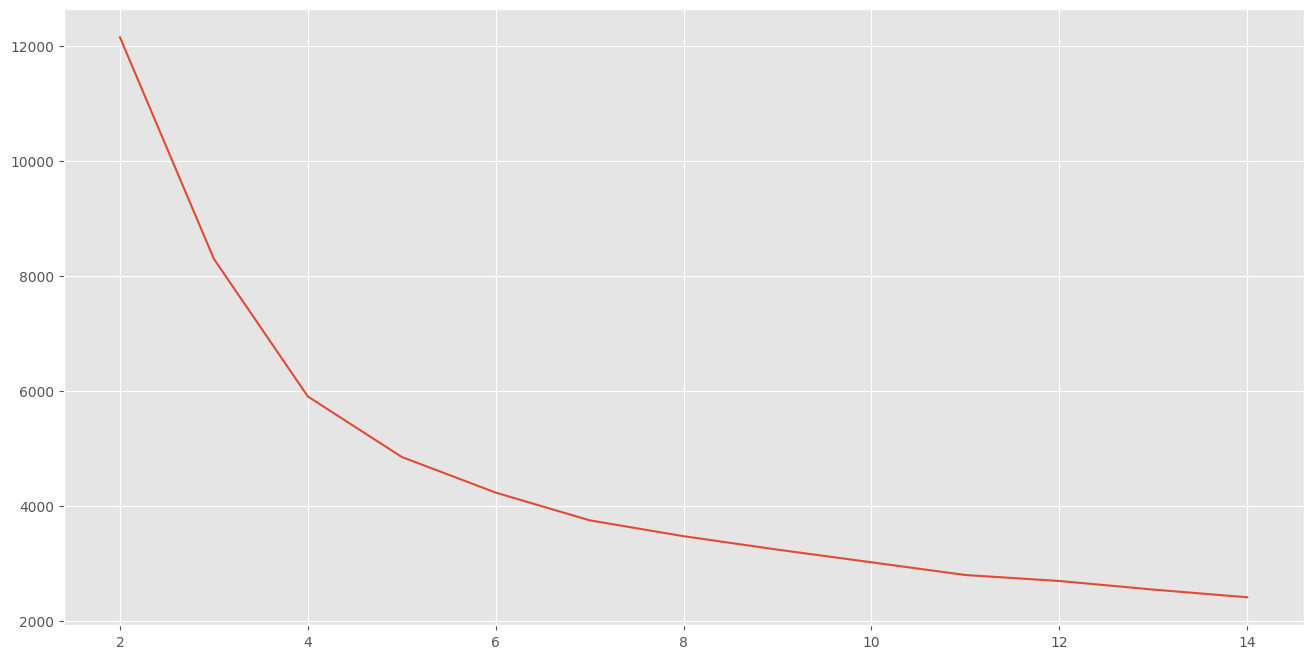

In [78]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")

# Buscamos en número de clusters donde se produce el mayor cambio de pendiente "elbow curve" = 4 o 5

In [79]:
pipe = Pipeline(
    steps = [
        ("Scaler", MinMaxScaler()),
        ("Clustering", KMeans(n_clusters = 4, n_init=10, random_state = 42))
    ]
)

In [80]:
pipe.fit(df_cluster)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Clustering',
                 KMeans(n_clusters=4, n_init=10, random_state=42))])

In [81]:
X_processed = df_cluster.copy()

In [82]:
labels = pipe.predict(df_cluster)

In [83]:
X_processed["cluster"] = labels

In [84]:
X_processed

,customer_ID,dias_ultima_compra,facturacion_total,pedido_min,pedido_max,pedido_mean,n_compras,cluster
0,15891,304.0,66.4,66.4,66.4,66.40,1,0
1,16203,120.0,96.7,96.7,96.7,96.70,1,3
2,16502,120.0,132.9,64.3,68.6,66.45,2,3
3,17457,242.0,56.0,56.0,56.0,56.00,1,0
4,17970,89.0,879.8,49.5,830.3,439.90,2,3
...,...,...,...,...,...,...,...,...
152749,1553456,0.0,56.7,56.7,56.7,56.70,1,3
152750,1553541,0.0,66.5,66.5,66.5,66.50,1,3
152751,1553559,0.0,73.0,73.0,73.0,73.00,1,3
152752,1553565,0.0,82.3,82.3,82.3,82.30,1,3


<Axes: >

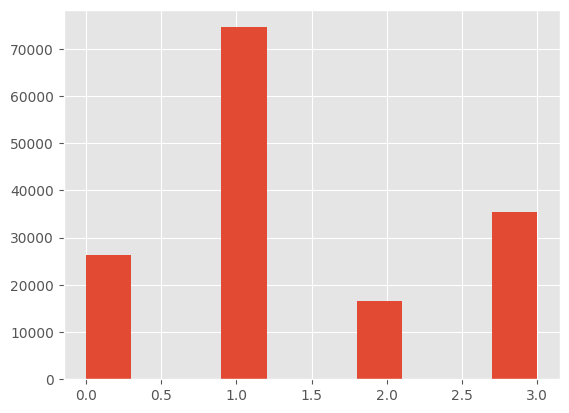

In [85]:
X_processed["cluster"].hist()

In [86]:
ficha_df = pd.DataFrame()

In [87]:
for i, col in enumerate(["facturacion_total", "n_compras", "dias_ultima_compra"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

<ipython-input-87-a753e06a36e7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-87-a753e06a36e7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-87-a753e06a36e7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)


In [88]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [89]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [90]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [91]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [92]:
ficha_df = tamaño_clusters.append(ficha_df)

<ipython-input-92-fb8174410a5c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = tamaño_clusters.append(ficha_df)


In [93]:
ficha_df = ficha_df.rename(columns = {
    0 : "Antiguos + ",
    1 : "Antiguos",
    2 : "Premium",
    3 : "Otros",
})

In [94]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

# 4 .- Clustering 2

ID de cliente en index
Edad, peso, altura, nómina...
> Normalizar valores. Probar con min max scaler, standardscaler, robustscaler(si hay outliers) o logaritmica si necesitamoss una distr normal

- **RECENCIA**  
 - Días desde la última compra.
 - Días desde la primera y última compra
- **FRECUENCIA**
 - Número de productos
- **MONETARIA**
 - Total facturación
 - Pedido medio

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans


# Escalar/Normalizar dataset
pipe = Pipeline(
    steps = [
        ("Scaler", MinMaxScaler()),
    ]
)

# Probar con >>  ("RobustScaler", RobustScaler(quantile_range =(0,99.0)))
# Probar a imputar nulos con >>  ("Imputer", KNNImputer())

In [114]:
df_scaled_transformed = pipe.fit_transform(df_cluster2)

In [115]:
 sse = {}

 for k in range(2,15):
  print(f"Fitting pipe with {k} clusters")

  clustering_model = KMeans(n_clusters = k, n_init=10)
  clustering_model.fit(df_scaled_transformed)

  sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


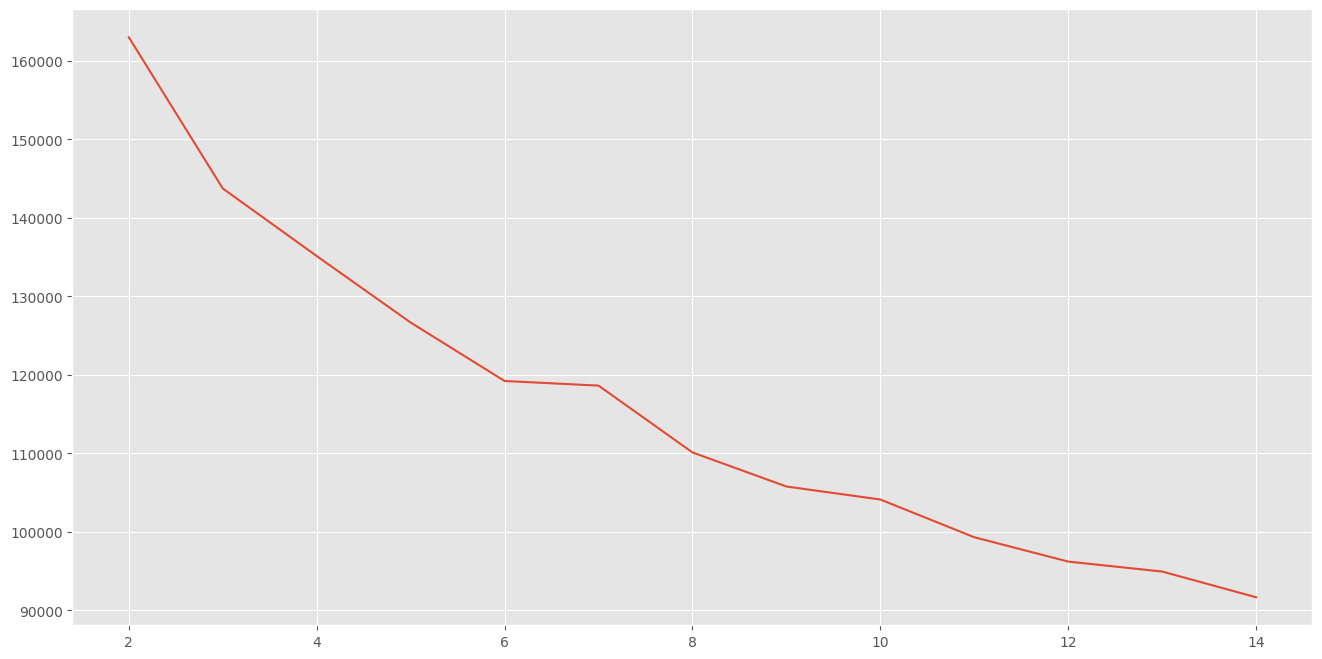

In [116]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")

# Buscamos en número de clusters donde se produce el mayor cambio de pendiente "elbow curve" = 4 o 5

In [117]:
pipe = Pipeline(
    steps = [
        ("Scaler", MinMaxScaler()),
        ("Clustering", KMeans(n_clusters = 7, n_init=10, random_state = 42))
    ]
)

In [118]:
pipe.fit(df_cluster2)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Clustering',
                 KMeans(n_clusters=7, n_init=10, random_state=42))])

In [119]:
X_processed = df_cluster2.copy()

In [120]:
labels = pipe.predict(df_cluster2)

In [121]:
X_processed["cluster"] = labels

In [122]:
ficha_df = pd.DataFrame()

In [123]:
for i, col in enumerate(["facturacion_total", "n_compras", "dias_ultima_compra","gender","age","salary"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

<ipython-input-123-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-123-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-123-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-123-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-123-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [127]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Frecuencia",
    "Recencia",
    "Sociodemográficos",
    "Sociodemográficos",
    "Sociodemográficos"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Género",
    "Edad",
    "Salario",
    "Código provincia"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [128]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [130]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [131]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [132]:
ficha_df = tamaño_clusters.append(ficha_df)

<ipython-input-132-fb8174410a5c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = tamaño_clusters.append(ficha_df)


In [133]:
ficha_df = ficha_df.rename(columns = {
    0 : "1",
    1 : "2",
    2 : "3",
    3 : "4",
    4 : "5",
    5 : "6",
    6 : "7",
    7 : "8",
    8 : "9",
})

In [134]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

# 4 .- Clustering 3

ID de cliente en index
Edad, peso, altura, nómina...
> Normalizar valores. Probar con min max scaler, standardscaler, robustscaler(si hay outliers) o logaritmica si necesitamoss una distr normal

- **RECENCIA**  
 - Días desde la última compra.
 - Días desde la primera y última compra
- **FRECUENCIA**
 - Número de productos
- **MONETARIA**
 - Total facturación
 - Pedido medio

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans


# Escalar/Normalizar dataset
pipe = Pipeline(
    steps = [
        ("RobustScaler", RobustScaler(quantile_range =(0,95.0))),
    ]
)

# Probar con >>  ("RobustScaler", RobustScaler(quantile_range =(0,95.0)))

In [136]:
df_cluster_3 = df_cluster3.reset_index()

In [137]:
df_scaled_transformed = pipe.fit_transform(df_cluster_3)

In [138]:
 sse = {}

 for k in range(2,15):
  print(f"Fitting pipe with {k} clusters")

  clustering_model = KMeans(n_clusters = k, n_init=10)
  clustering_model.fit(df_scaled_transformed)

  sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


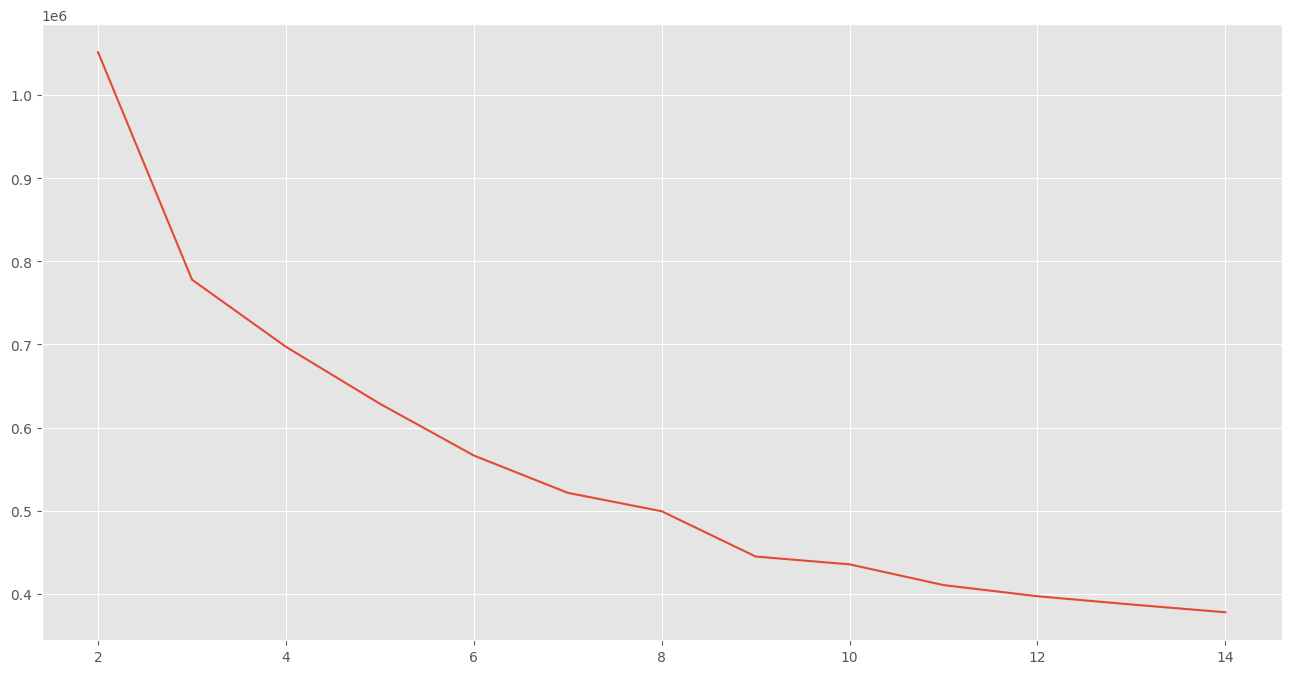

In [139]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")

# Buscamos en número de clusters donde se produce el mayor cambio de pendiente "elbow curve" = 4 o 5

In [140]:
pipe = Pipeline(
    steps = [
        ("RobustScaler", RobustScaler(quantile_range =(0,95.0))),
        ("Clustering", KMeans(n_clusters = 5, n_init=10, random_state = 42))
    ]
)

In [141]:
pipe.fit(df_cluster3)

Pipeline(steps=[('RobustScaler', RobustScaler(quantile_range=(0, 95.0))),
                ('Clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [142]:
X_processed = df_cluster3.copy()

In [143]:
labels = pipe.predict(df_cluster3)

In [144]:
X_processed["cluster"] = labels

In [145]:
ficha_df = pd.DataFrame()

In [146]:
for i, col in enumerate(["facturacion_total", "n_compras", "dias_ultima_compra","gender","age","salary"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

<ipython-input-146-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-146-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-146-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-146-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = ficha_df.append(resumen_data)
<ipython-input-146-6785306d7aeb>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [147]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Frecuencia",
    "Recencia",
    "Sociodemográficos",
    "Sociodemográficos2",
    "Sociodemográficos3"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Género",
    "Edad",
    "Salario"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [148]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [149]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [150]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [151]:
ficha_df = tamaño_clusters.append(ficha_df)

<ipython-input-151-fb8174410a5c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ficha_df = tamaño_clusters.append(ficha_df)


In [152]:
ficha_df = ficha_df.rename(columns = {
    0 : "Jóvenes_",
    1 : "Mid-age_1",
    2 : "Mid-age_2",
    3 : "Mid-age_3",
    4 : "Seniors_"
})

In [153]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [154]:
clusters = X_processed.copy()

In [155]:
from google.colab import files
clusters.to_csv('clusters.csv', encoding = 'utf-8-sig')
files.download('clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>